In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from pydub import AudioSegment
import numpy as np
import io
from scipy import stats

# plt use ggplot stylesheet
plt.style.use('ggplot')

In [2]:
# Load the JSON file
with open('temp/image-scoring-matching.json', 'r') as f:
    data = json.load(f)

len(data)
data[0]

{'_id': {'$oid': '697c9701bc48def48d5f55ee'},
 'study_metadata': {'project': 'image-scoring',
  'experiment': 'image-scoring-matching',
  'version': '1.0.0',
  'study_description': 'matching sounds to video clips',
  'date': '2026-01-30',
  'time': '11:32:28'},
 'session_info': {'condition': 'referential'},
 'prolific': {'prolificStudyID': '697c494f97eda2e607242f58',
  'prolificSessionID': '697c96c50cdf873b6c14dee0',
  'prolificID': '5bcc60b95c2b810001dc68e2'},
 'selected_choice': 7,
 'rt': 11852.40000000596,
 'participant_id': 9,
 'original_trial_index': 2,
 'repetition': 1,
 'presentation_order': 0,
 'correct_answer_position': 0,
 'choice_mapping': [0, 1, 2, 6, 7, 8, 3, 4, 5],
 'master_grid_shuffle': [0, 1, 2, 6, 7, 8, 3, 4, 5],
 'trial_type': 'audio-amoeba-match',
 'trial_index': 7,
 'time_elapsed': 50600,
 'internal_node_id': '0.0-7.0',
 'correct': False}

### success by condition

In [3]:
matching_trials = [entry for entry in data if entry.get('trial_type') == 'audio-amoeba-match']
print(f"Total matching trials: {len(matching_trials)}")

participants = set(entry['prolific']['prolificSessionID'] for entry in matching_trials)
print(f"Total participants: {len(participants)}")


Total matching trials: 2918
Total participants: 168


In [4]:
# throw out participants who didn't complete all 18 trials
complete_participants = {pid for pid in participants if sum(1 for entry in matching_trials if entry['prolific']['prolificSessionID'] == pid) == 18}
matching_trials = [entry for entry in matching_trials if entry['prolific']['prolificSessionID'] in complete_participants]
print(f"Total participants after filtering: {len(complete_participants)}")

Total participants after filtering: 161


In [5]:
success_pct = len([x for x in matching_trials if x.get('correct')])/len(matching_trials)
print(len([x for x in matching_trials if x.get('correct') == True]), len(matching_trials))
print(f'overall correct percentage: {success_pct:.3f}')

374 2898
overall correct percentage: 0.129


## by condition

In [6]:
referential_trials = [entry for entry in matching_trials if entry.get('session_info').get('condition') == 'referential']
pleasing_trials = [entry for entry in matching_trials if entry.get('session_info').get('condition') == 'musical']
print(f'found {len(referential_trials)} ref trials and {len(pleasing_trials)} pleasing trials')


found 1458 ref trials and 1440 pleasing trials


In [7]:
referential_correct_pct = len([x for x in referential_trials if x.get('correct')])/len(referential_trials)
pleasing_correct_pct = len([x for x in pleasing_trials if x.get('correct')])/len(pleasing_trials)
print(f'ref: {referential_correct_pct:.3f}, pleasing: {pleasing_correct_pct:.3f}')

ref: 0.132, pleasing: 0.126


In [8]:
# p-value for difference in mean accuracy between conditions
ref_correct = np.array([1 if x.get('correct') else 0 for x in referential_trials], dtype=float)
pleasing_correct = np.array([1 if x.get('correct') else 0 for x in pleasing_trials], dtype=float)

mean_diff = ref_correct.mean() - pleasing_correct.mean()
ttest_res = stats.ttest_ind(ref_correct, pleasing_correct, equal_var=False)

print(f'ref mean: {ref_correct.mean():.3f}, pleasing mean: {pleasing_correct.mean():.3f}')
print(f'mean difference (ref - pleasing): {mean_diff:.3f}')
print(f't = {ttest_res.statistic:.3f}, p = {ttest_res.pvalue:.6f}')

ref mean: 0.132, pleasing mean: 0.126
mean difference (ref - pleasing): 0.007
t = 0.536, p = 0.591927


In [11]:
chance = 1 / 9

ref_t = stats.ttest_1samp(ref_correct, popmean=chance)
pleasing_t = stats.ttest_1samp(pleasing_correct, popmean=chance)

ref_p_one_sided = ref_t.pvalue / 2 if ref_t.statistic > 0 else 1 - ref_t.pvalue / 2
pleasing_p_one_sided = pleasing_t.pvalue / 2 if pleasing_t.statistic > 0 else 1 - pleasing_t.pvalue / 2

print(f"ref: t={ref_t.statistic:.3f}, one-sided p={ref_p_one_sided:.3f}")
print(f"pleasing: t={pleasing_t.statistic:.3f}, one-sided p={pleasing_p_one_sided:.3f}")

ref: t=2.395, one-sided p=0.008
pleasing: t=1.669, one-sided p=0.048


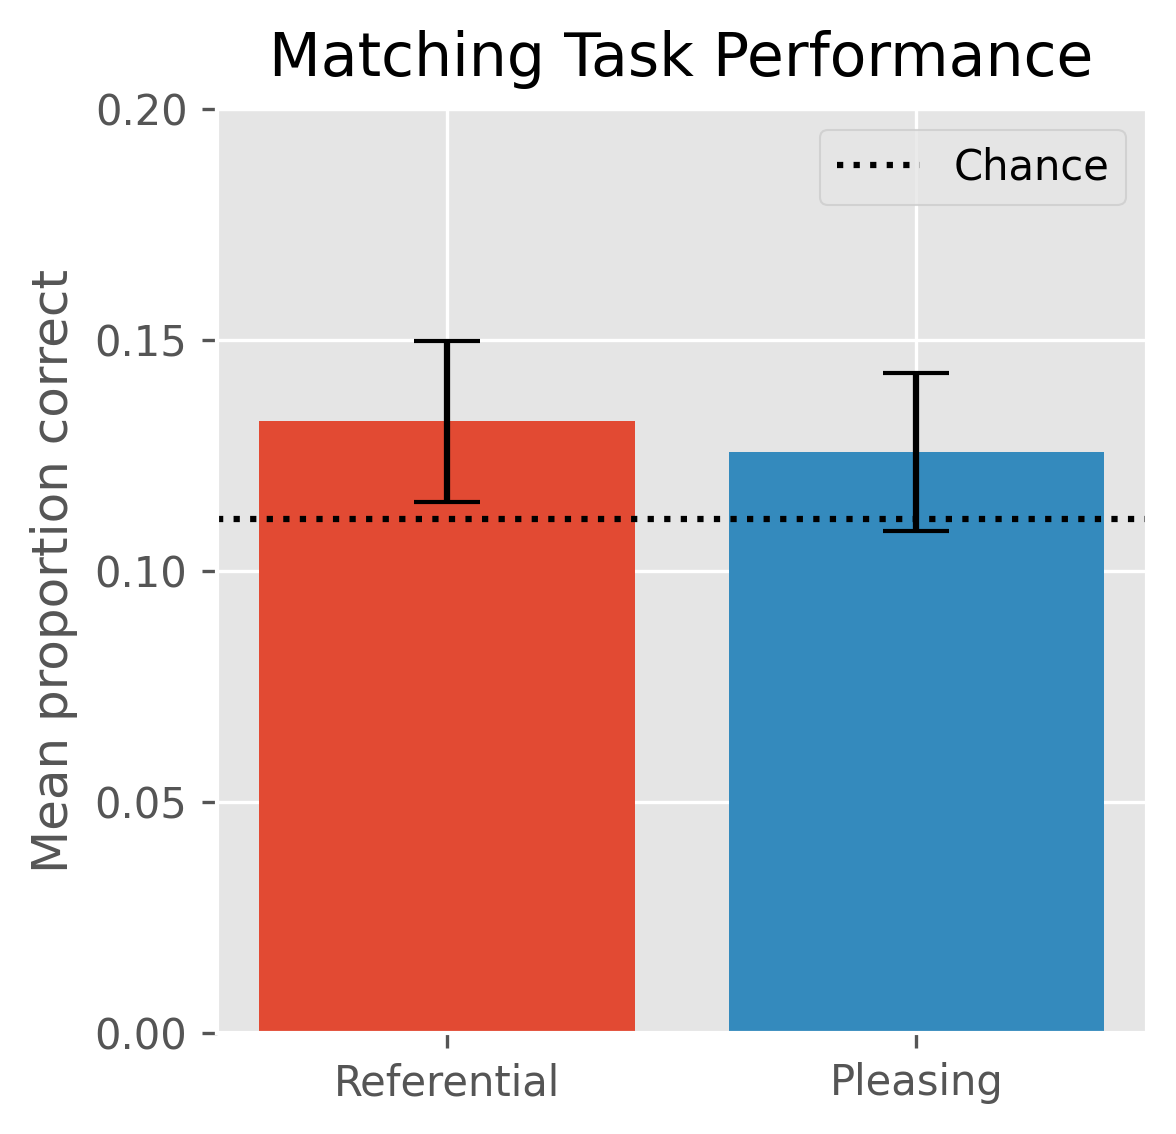

In [12]:
def mean_ci(x, alpha=0.05):
    n = len(x)
    m = np.mean(x)
    se = np.std(x, ddof=1) / np.sqrt(n)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    h = tcrit * se
    return m, h

m_ref, h_ref = mean_ci(ref_correct)
m_mus, h_mus = mean_ci(pleasing_correct)

conds = ['Referential', 'Pleasing']
means = [m_ref, m_mus]
errs = [h_ref, h_mus]

fig, ax = plt.subplots(figsize=(4,4), dpi=300)
x = np.arange(len(conds))
ax.bar(x, means, yerr=errs, capsize=8, color=['C0','C1'])
ax.set_xticks(x)
ax.set_xticklabels(conds)
ax.set_ylabel('Mean proportion correct')
ax.set_ylim(0, 0.2)
ax.set_yticks(np.linspace(0, 0.2, 5))
ax.set_title('Matching Task Performance', pad=8)

ax.axhline(y=1/9, color='k', linestyle=':', linewidth=1.5, label='Chance')
ax.legend()

plt.show()